# Directional and Inter-acquisition Variation Analysis of Diffusion Signals


In [10]:
import mat73
import scipy.io as sio
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt
from matplotlib import patches
import pylab as pl
from DAVID_functions import calc_mean_adc, calc_adc_erd, calc_adc_all_lms_fits, calc_adc_all_acq
import PIDS_functions as pf
from tqdm.notebook import tqdm
import skimage
from skimage import morphology
from matplotlib import colors as cls
from skimage import morphology
import os

In [2]:
# Change the following line for a new case
BASE_ADDRESS = 'C://Users//Gundogdu//Desktop//University of Chicago//PATIENT_DATA//IRB17//pat083'
data_address = os.path.join(BASE_ADDRESS, 'master.mat')



print('Loading data')
try:
    data = sio.loadmat(data_address)
except FileNotFoundError:
    BASE_ADDRESS = 'C://Users//mrirc//Desktop//Master Data//IRB17//pat083//'
    data_address = os.path.join(BASE_ADDRESS, 'master.mat')
    try:
        data = sio.loadmat(data_address)
    except NotImplementedError:
        data = mat73.loadmat(data_address)
print('Data loaded')

Loading data
Data loaded


In [3]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print(color.BOLD + color.GREEN + 'The variables in this data file are:' + color.END)
for f in data.keys():
    try:
        print(f'{f} : {data[f].shape}')
    except:
        continue

The variables in this data file are:
DCE : (192, 192, 53, 60)
T1 : (400, 400, 34)
T2 : (576, 576, 34)
T2_3D : (288, 288, 145)
TE : (4,)
TE_norm : (4,)
areScaled : ()
b : (4,)
b0 : (128, 128, 34)
b1 : (128, 128, 34, 6)
b2 : (128, 128, 34, 6)
b3 : (128, 128, 34, 12)
b4 : (128, 128, 34, 18)
benign_mask : (128, 128, 34)
cancer_mask : (128, 128, 34)
hybrid_data : (128, 128, 34, 4, 4)
noise_mask : (128, 128, 34)
numSlices : ()
raw : (128, 128, 34, 5, 3, 6)
scanned_image : (288, 288, 145)


In [4]:
hybrid_data = data['hybrid_data']
cancer_mask = data['cancer_mask']
benign_mask = data['benign_mask']
noise_mask = data['noise_mask']
hybrid_raw = data['hybrid_raw']
b_values = data['b']

## Calculate signal distributions on (1) Rectum, (2) Healthy Prostate and (3) Cancer

Text(0.5, 1.0, 'cancer, skewness = 0.36')

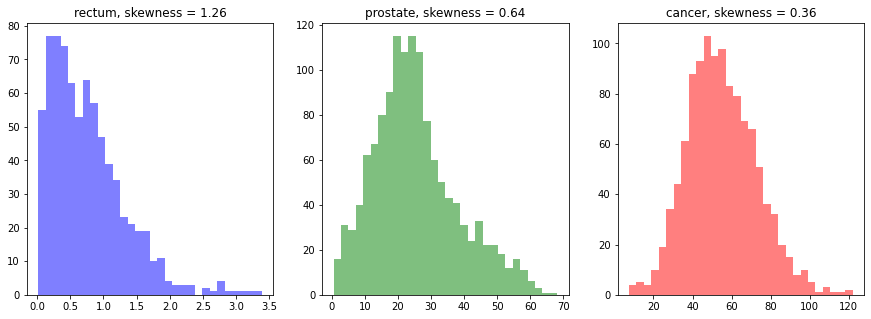

In [5]:
hybrid_raw_reshaped = hybrid_data.copy()
for b in range(4):
    for te in range(4):
        hybrid_raw_reshaped[:, :, :, b, te] = np.mean(hybrid_raw[b][te], -1) if b else hybrid_raw[b][te]
_cancer = []
_noise = []
_benign = []
_cancer_locations = []
_benign_locations = []
cancer_slices = []
benign_slices = []

for sliceIndex in range(hybrid_raw_reshaped.shape[2]):
    if np.sum(cancer_mask[:, :, sliceIndex].flatten()):
        I, J = np.where(cancer_mask[:, :, sliceIndex])
        _cancer.append([list(hybrid_raw[3][0][i, j, sliceIndex, :]) for i,j in zip(I,J)])
        _cancer_locations.append([(i,j, sliceIndex) for i,j in zip(I,J)])
        cancer_slices.append(sliceIndex)
    if np.sum(benign_mask[:, :, sliceIndex].flatten()):
        I, J = np.where(benign_mask[:, :, sliceIndex])
        _benign.append([list(hybrid_raw[3][0][i, j, sliceIndex, :]) for i,j in zip(I,J)])
        _benign_locations.append([(i,j, sliceIndex) for i,j in zip(I,J)])
        benign_slices.append(sliceIndex)
    if np.sum(noise_mask[:, :, sliceIndex].flatten()):
        I, J = np.where(noise_mask[:, :, sliceIndex])
        _noise.append([list(hybrid_raw[3][0][i, j, sliceIndex, :]) for i,j in zip(I,J)])

cancer_voxels = []
def flatten_list(data):
    for element in data:
        if type(element) == list:
            flatten_list(element)
        else:
            cancer_voxels.append(element)

flatten_list(_cancer)

cancer_voxels = np.asarray(cancer_voxels) 

benign_voxels = []
def flatten_list(data):
    for element in data:
        if type(element) == list:
            flatten_list(element)
        else:
            benign_voxels.append(element)

flatten_list(_benign)
benign_voxels = np.asarray(benign_voxels) 

noise_voxels = []
def flatten_list(data):
    for element in data:
        if type(element) == list:
            flatten_list(element)
        else:
            noise_voxels.append(element)

flatten_list(_noise)
noise_voxels = np.asarray(noise_voxels) 



cancer_locations = []
def flatten_list(data):
    for element in data:
        if type(element) == list:
            flatten_list(element)
        else:
            cancer_locations.append(element)

flatten_list(_cancer_locations)


benign_locations = []
def flatten_list(data):
    for element in data:
        if type(element) == list:
            flatten_list(element)
        else:
            benign_locations.append(element)

flatten_list(_benign_locations)

fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].hist(noise_voxels.flatten(), bins=30, alpha=0.5, label='cancer ROI', color='blue')
ax[0].set_title(f'rectum, skewness = {skew(noise_voxels.flatten()):.2f}')
ax[1].hist(benign_voxels.flatten(), bins=30,alpha=0.5, label='cancer ROI', color='green')
ax[1].set_title(f'prostate, skewness = {skew(benign_voxels.flatten()):.2f}')
ax[2].hist(cancer_voxels.flatten(),bins=30, alpha=0.5, label='cancer ROI', color='red')
ax[2].set_title(f'cancer, skewness = {skew(cancer_voxels.flatten()):.2f}')

## Apply Soft ERD and compare the Contrast Ratio

Mean ADC, cancer=1.06,   benign=1.43,   CR=1.35
ERD, cancer=1.00,   benign=1.42,   CR=1.41


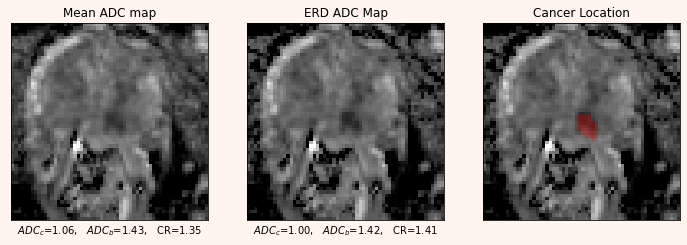

In [6]:
ROI_start = 35
ROI_range = 95
adc = calc_mean_adc(hybrid_raw_reshaped[:, :, :, 3, 0], hybrid_raw_reshaped[:, :, :, 0, 0], b_values[3])
# cancer slice is chosen to be the one with the largest marked area
cancer_slice = cancer_slices[np.argmax([len(_cancer[i]) for i in range(len(_cancer))])]
fig, ax = plt.subplots(1,3, figsize=(12,4))
adc_c = 'ADC_c'
adc_b = 'ADC_b'
noise = np.std(noise_voxels)
cancer_mean = np.mean([adc[i, j, k] for i, j ,k in cancer_locations])
ben_mean = np.mean([adc[i, j, k] for i, j ,k in benign_locations])
print(f'Mean ADC, cancer={cancer_mean:.2f},   benign={ben_mean:.2f},   CR={(ben_mean/cancer_mean):.2f}')
ax[0].imshow(adc[ROI_start:ROI_range,ROI_start:ROI_range, cancer_slice], cmap='gray', vmin=0.3, vmax=3)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel(f'${{{adc_c}}}$={cancer_mean:.2f},   ${{{adc_b}}}$={ben_mean:.2f},   CR={(ben_mean/cancer_mean):.2f}')
ax[0].set_title(f'Mean ADC map')
adc_erd = calc_adc_erd(hybrid_raw[3][0], hybrid_raw[0][0], set(benign_slices).union(cancer_slices), b_value=1500, noise_std=noise)
cancer_mean = np.mean([adc_erd[i, j, k] for i, j ,k in cancer_locations])
ben_mean = np.mean([adc_erd[i, j, k] for i, j ,k in benign_locations])
print(f'ERD, cancer={cancer_mean:.2f},   benign={ben_mean:.2f},   CR={(ben_mean/cancer_mean):.2f}')
ax[1].imshow(adc_erd[ROI_start:ROI_range,ROI_start:ROI_range,cancer_slice], cmap='gray', vmin=0.3, vmax=3);
ax[1].set_xticks([]);
ax[1].set_yticks([]);
ax[1].set_xlabel(f'${{{adc_c}}}$={cancer_mean:.2f},   ${{{adc_b}}}$={ben_mean:.2f},   CR={(ben_mean/cancer_mean):.2f}');
ax[1].set_title('ERD ADC Map');


ax[2].imshow(adc_erd[ROI_start:ROI_range,ROI_start:ROI_range,cancer_slice], cmap='gray', vmin=0.3, vmax=3);
ax[2].set_xticks([]);
ax[2].set_yticks([]);
ax[2].set_title('Cancer Location');
cmask = cancer_mask[ROI_start:ROI_range,ROI_start:ROI_range,cancer_slice]
cmask[cmask==0] = np.nan
ax[2].imshow(cmask, cmap='autumn', alpha=0.3)
fig.set_facecolor("seashell")



### TODO: Save the ERD-applied matrices and do the ERD for other TE's and b-values as well

## Calculate Inter-direction variation via triangle plots

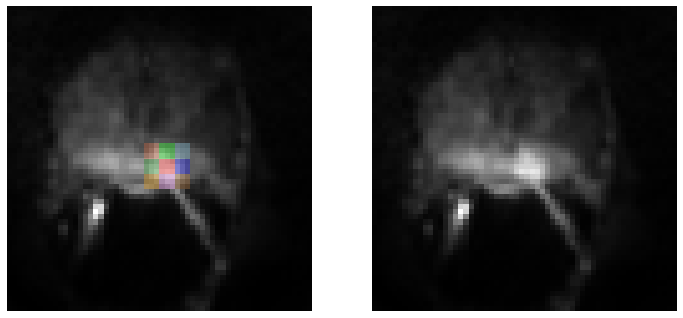

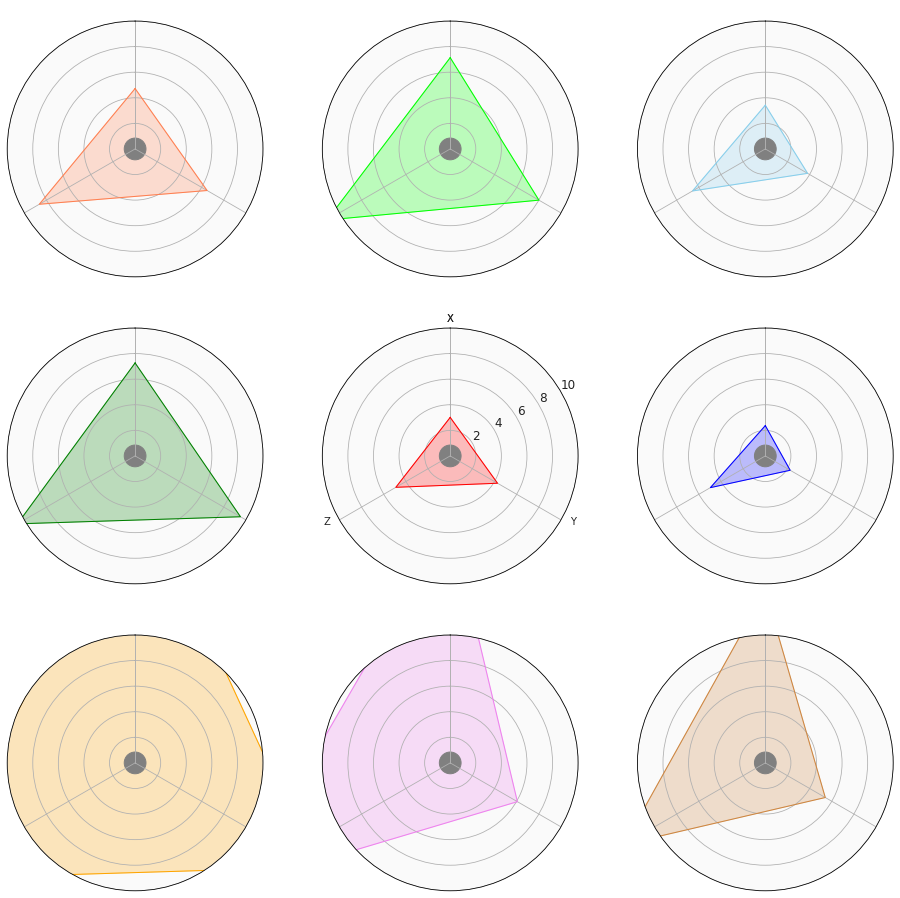

In [7]:
cancer_center = np.median(np.asarray([np.asarray(v[0:2]) for v in cancer_locations if v[2]==cancer_slice]), axis=0)
img = hybrid_raw_reshaped[ROI_start:ROI_range, ROI_start:ROI_range, cancer_slice, 3, 0]
figure, ax = plt.subplots(1,2, figsize=(12,6))
colors = [["coral", "lime", "skyblue"],["green", "red", "blue"],["orange", "violet", "peru"]]
for i in range(-1,2):
        for j in range(-1,2):
            x_start = cancer_center[1]-1.5 + i*3 - ROI_start
            y_start = cancer_center[0]-1.5 + j*3 - ROI_start
            #rect = patches.Rectangle((x_start+1, y_start+1), 1, 1, edgecolor='black', facecolor='none', alpha=1.0, lw = 2)
            rect2 = patches.Rectangle((x_start, y_start), 3, 3, edgecolor='none', facecolor=colors[j+1][i+1], alpha=0.3)
            ax[0].imshow(img, cmap='gray')
            ax[0].axis('off')
            #ax.add_patch(rect)
            ax[0].add_patch(rect2)

noise_range = noise/np.sqrt(2-np.pi/2)

ax[1].imshow(img, cmap='gray')
ax[1].axis('off')
labels = ['X', 'Y', 'Z','X']
labels2 = [' ', ' ', ' ',' ']
num_vars = 3
fig, ax = plt.subplots(3, 3, figsize=(16, 16),subplot_kw=dict(polar=True))
nec = hybrid_raw[3][0].shape[3]//3
for r in range(-1,2):
    for c in range(-1,2):
        x_start = int(cancer_center[0]-1 + r*3)
        y_start = int(cancer_center[1]-1 + c*3)
        ROI = hybrid_raw[3][0][x_start : x_start + 3, y_start : y_start + 3, cancer_slice, :]
        x_range = np.std(ROI[1, 1, :nec])# - np.amin(ROI[:, :, :nec], 2)
        y_range = np.std(ROI[1, 1, nec:2*nec])# - np.amin(ROI[:, :, nec:2*nec], 2)
        z_range = np.std(ROI[1, 1, 2*nec:])# - np.amin(ROI[:, :, 2*nec:], 2)
        #ranges = [x_range.mean(),  y_range.mean(), z_range.mean()]
        ranges = [x_range,  y_range, z_range]
        values = ranges

        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        values += values[:1]
        angles += angles[:1]
        ax[r + 1 ,c + 1].set_ylim(0, 10)
        ax[r +1 , c + 1].plot(angles, values, color=colors[r + 1][c + 1], linewidth=1)
        ax[r +1 , c + 1].fill(angles, values, color=colors[r + 1][c + 1], alpha=0.25)
        if not r and not c:
            ax[r +1 , c + 1].set_thetagrids(np.degrees(angles), labels)     
        else :
            ax[r +1 , c + 1].set_thetagrids(np.degrees(angles), labels2)
            ax[r +1 , c + 1].set_yticklabels([])
        ax[r +1 , c + 1].set_theta_offset(np.pi / 2)
        ax[r +1 , c + 1].set_theta_direction(-1)
        for label, angle in zip(ax[r +1 , c + 1].get_xticklabels(), angles):
            label.set_horizontalalignment('center')
            label.set_verticalalignment('bottom')
            if angle in (0, np.pi):
                label.set_horizontalalignment('center')
                label.set_verticalalignment('top')
        ax[r +1 , c + 1].set_rlabel_position(180 / num_vars)
        ax[r +1 , c + 1].tick_params(colors='#222222')
        circle2 = pl.Circle((0, 0), noise_range, transform=ax[r+1,c+1].transData._b, color="gray", alpha=1, fill=True)
        ax[r +1 , c + 1].add_artist(circle2)
        ax[r +1 , c + 1].tick_params(axis='y', labelsize=12)
        ax[r +1 , c + 1].set_facecolor('#FAFAFA')


# Calculate ADC variation that arises due to the inter-acquisition variation

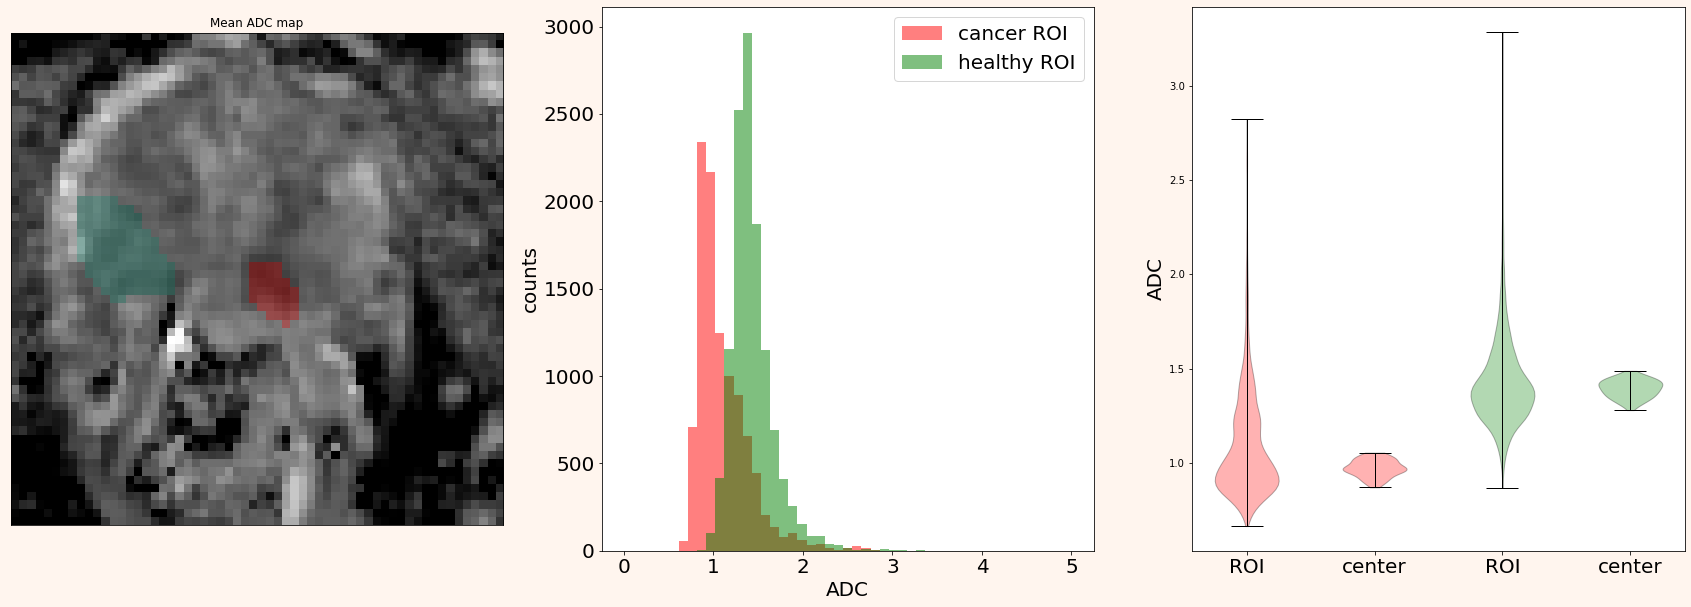

In [8]:

adc_variation = calc_adc_all_lms_fits(b_values, hybrid_raw, cancer_slice)
benign_slice = benign_slices[np.argmax([len(_benign[i]) for i in range(len(_benign))])]
benign_center = np.median(np.asarray([np.asarray(v[0:2]) for v in benign_locations if v[2]==benign_slice]), axis=0)
cancer_center = np.median(np.asarray([np.asarray(v[0:2]) for v in cancer_locations if v[2]==cancer_slice]), axis=0)

fig, ax = plt.subplots(1,3, figsize=(30,10))

ax[0].imshow(adc[ROI_start:ROI_range,ROI_start:ROI_range, cancer_slice], cmap='gray', vmin=0.3, vmax=3)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title(f'Mean ADC map')
cmask = cancer_mask[ROI_start:ROI_range,ROI_start:ROI_range, cancer_slice]
cmask[cmask==0] = np.nan
ax[0].imshow(cmask, cmap='autumn', alpha=0.3)
bmask = benign_mask[ROI_start:ROI_range,ROI_start:ROI_range, benign_slice]
bmask[bmask==0] = np.nan
ax[0].imshow(bmask, cmap='summer', alpha=0.3)


fig.set_facecolor("seashell")


cancer_adcs = np.asarray([adc_variation[v[0], v[1]] for v in cancer_locations]).flatten()
benign_adcs = np.asarray([adc_variation[v[0], v[1]] for v in benign_locations]).flatten()
cancer_center_var = adc_variation[int(cancer_center[0]), int(cancer_center[1])]
benign_center_var = adc_variation[int(benign_center[0]), int(benign_center[1])]
bins = np.linspace(0, 5, 50)
ax[1].hist(cancer_adcs, bins, alpha=0.5, label='cancer ROI', color='red')
ax[1].hist(benign_adcs, bins, alpha=0.5, label='healthy ROI', color='green')
ax[1].legend(loc='upper right', prop={'size': 20})
ax[1].tick_params(axis='x', labelsize=20)
ax[1].tick_params(axis='y', labelsize=20)
ax[1].set_ylabel('counts', fontsize=20)
ax[1].set_xlabel('ADC', fontsize=20)

labels = ['ROI', 'center', 'ROI', 'center']


b=ax[2].violinplot([cancer_adcs, cancer_center_var, benign_adcs, benign_center_var])
ax[2].xaxis.set_tick_params(direction='out')
ax[2].xaxis.set_ticks_position('bottom')
ax[2].set_xticks(np.arange(1, len(labels) + 1))
ax[2].set_xticklabels(labels)
ax[2].tick_params(axis='x', labelsize=20)
ax[2].set_ylabel('ADC', fontsize=20)
for i, pc in enumerate(b['bodies']):
    pc.set_edgecolor('black')
    if i<2:
        pc.set_facecolor('red')
    else:
        pc.set_facecolor('green')
b['cbars'].set_color('black')
b['cbars'].set_linewidth(1)
b['cmaxes'].set_color('black')
b['cmaxes'].set_linewidth(1)
b['cmins'].set_color('black')
b['cmins'].set_linewidth(1)



# ERD Filtering

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

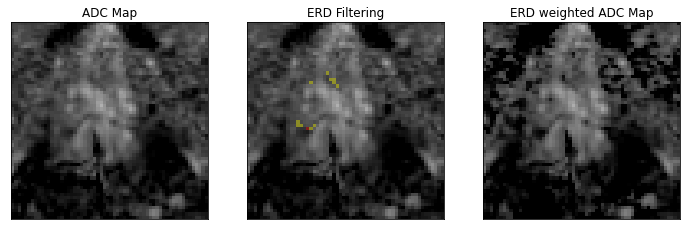

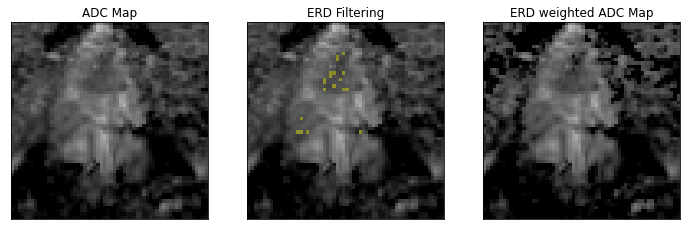

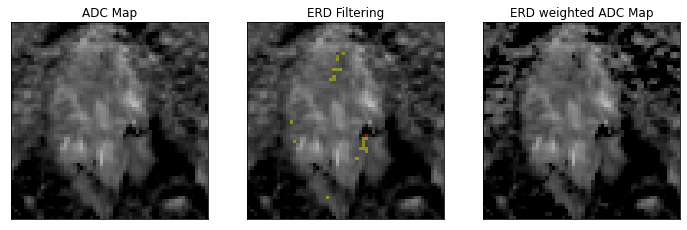

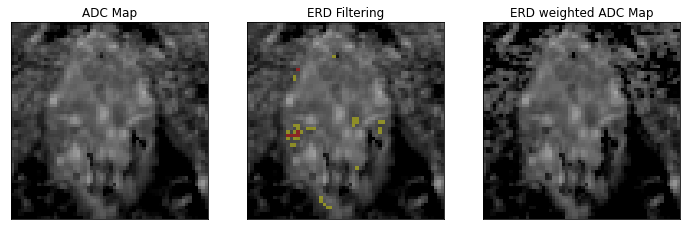

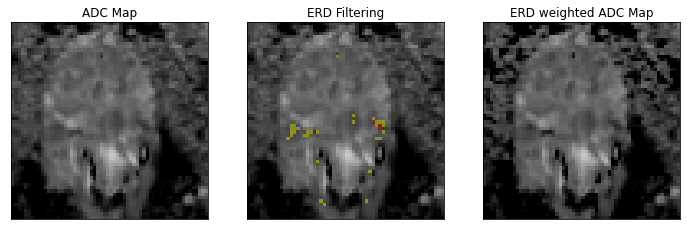

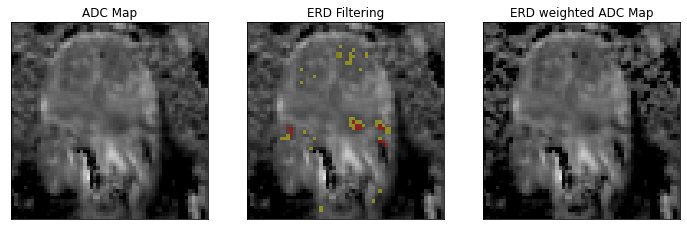

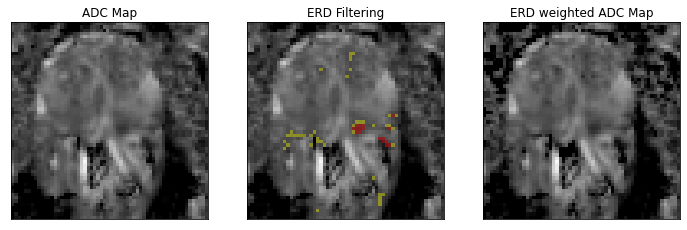

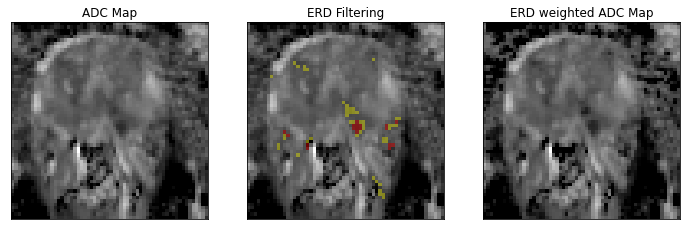

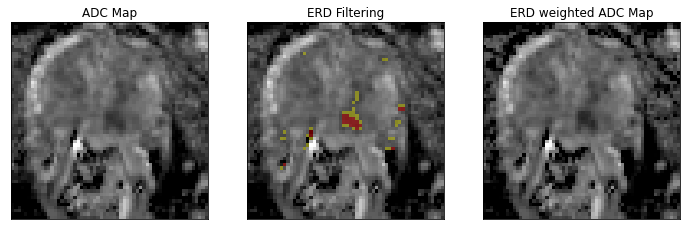

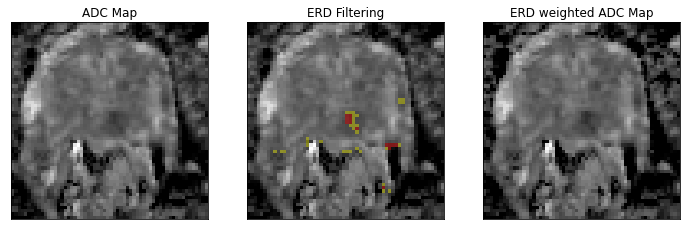

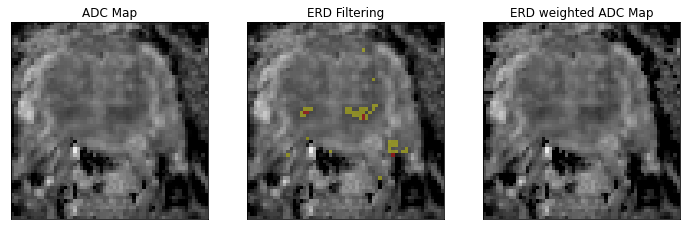

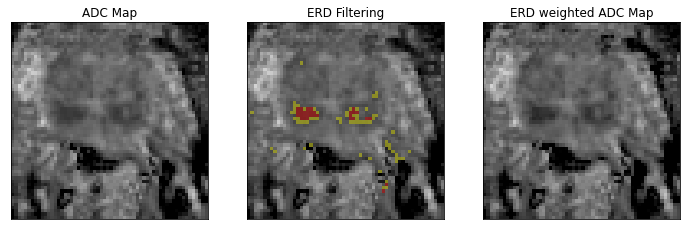

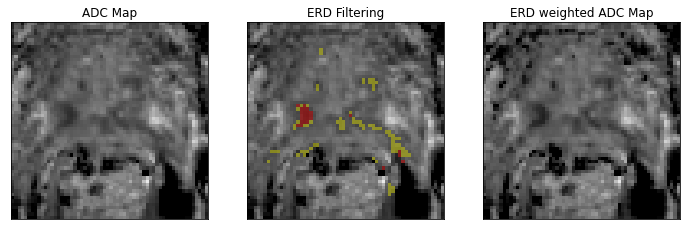

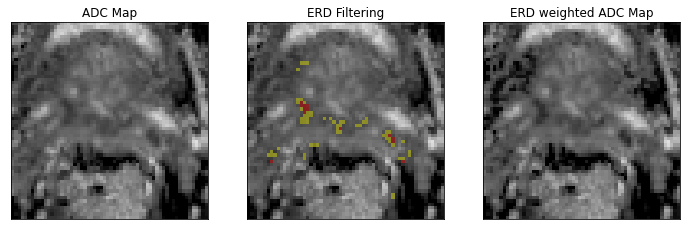

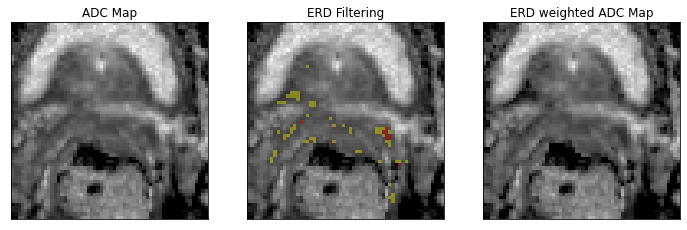

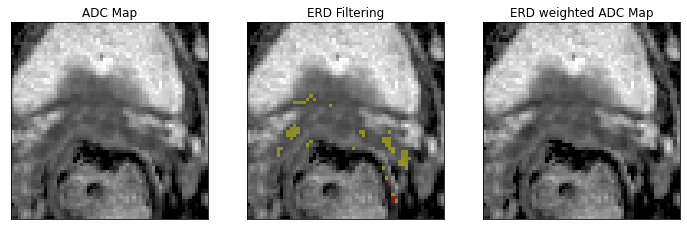

In [17]:
ERD_th = 1.04
adc_acq = calc_adc_all_acq(hybrid_raw[3][0][ROI_start:ROI_range, ROI_start:ROI_range, :, :], hybrid_raw[0][0][ROI_start:ROI_range, ROI_start:ROI_range, :])
ERD_filter = adc_acq < ERD_th
adc_erd = calc_adc_erd(hybrid_raw[3][0], hybrid_raw[0][0], range(9, 25), b_value=1500, noise_std=noise)
for a in range(ERD_filter.shape[3]):
    ERD_filter[:, :, :, a] = morphology.remove_small_objects(ERD_filter[:, : ,:, a].astype(bool), min_size=20, connectivity=27).astype(float)
for _slice in range(9, 25):
    # Detecting the prostate area via PIDS analysis
    PIDS_1, PIDS_2, PIDS_3, PIDS_4 = pf.detect_PIDS_slice(b_values, hybrid_data[ROI_start:ROI_range, ROI_start:ROI_range, _slice, :, :])
    prostate_mask = PIDS_1.astype(float) + PIDS_2.astype(float)
    for i in range(0,3):
        for j in range(0,2):
            prostate_mask += PIDS_3[:,:,i, j].astype(float)
    prostate_mask = 1 - (prostate_mask>0).astype(float)
    prostate_mask = morphology.remove_small_objects(prostate_mask.astype(bool), min_size=50, connectivity=50)
    prostate_mask = morphology.remove_small_holes(prostate_mask, area_threshold=50, connectivity=1)
    prostate_mask = prostate_mask * (hybrid_raw[0][0][ROI_start:ROI_range, ROI_start:ROI_range, _slice]>40).astype(float)

    ERD_map = np.mean(ERD_filter[:, :, _slice, :], 2) * (prostate_mask)
    ERD_map [ERD_map < 0.5] = 0 ## <------ Here's where we question the coherence of acquisitions
    ERD_map[ERD_map==0] = np.nan
    ERD_map [ERD_map < 0.8 ] = 0.1
    ERD_map [ERD_map >= 0.8] = 0.2
    cmap = cls.ListedColormap(['yellow', 'red'])
    fig, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].imshow(adc[ROI_start:ROI_range, ROI_start:ROI_range, _slice], cmap='gray', vmin=0.3, vmax=3)
    ax[0].set_title(f'ADC Map')
    ax[0].set_xticks([]);
    ax[0].set_yticks([]);
    ax[1].imshow(adc[ROI_start:ROI_range, ROI_start:ROI_range, _slice], cmap='gray', vmin=0.3, vmax=3)
    ax[1].imshow(ERD_map, cmap=cmap,vmin=0.1,vmax=0.2,alpha = 0.4)
    ax[1].set_title(f'ERD Filtering')
    ax[1].set_xticks([]);
    ax[1].set_yticks([]);
    ax[2].imshow(adc_erd[ROI_start:ROI_range,ROI_start:ROI_range, _slice], cmap='gray', vmin=0.3, vmax=3);
    ax[2].set_xticks([]);
    ax[2].set_yticks([]);
    #ax[2].set_xlabel(f'${{{adc_c}}}$={cancer_mean:.2f},   ${{{adc_b}}}$={ben_mean:.2f},   CR={(ben_mean/cancer_mean):.2f}');
    ax[2].set_title('ERD weighted ADC Map');

In [16]:
ERD_filter.shape[3]

12